# Imports, downloads and dependency management


In [ ]:
!wget https://expressexpense.com/large-receipt-image-dataset-SRD.zip
!unzip large-receipt-image-dataset-SRD.zip

In [70]:
!pip install pytesseract
!pip install terminaltables
!pip install wand
!pip install scipy
!pip install datefinder
!apt install tesseract-ocr
!apt install libtesseract-dev
!apt install imagemagick
!apt-get install tesseract-ocr-eng  
!apt-get install tesseract-ocr-tam  
!apt-get install tesseract-ocr-deu 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest vers

In [72]:
import io
import os
import time
import cv2
import numpy as np
import fnmatch
import json
import datefinder
import re
import dateutil.parser
from collections import namedtuple
from difflib import get_close_matches
from collections import defaultdict
from terminaltables import SingleTable
from PIL import Image
from pytesseract import pytesseract
from wand.image import Image as WandImage
from scipy.ndimage import interpolation as inter
from google.colab.patches import cv2_imshow

# Preprocessing 



---------------
ORIGINAL IMAGE
--------------






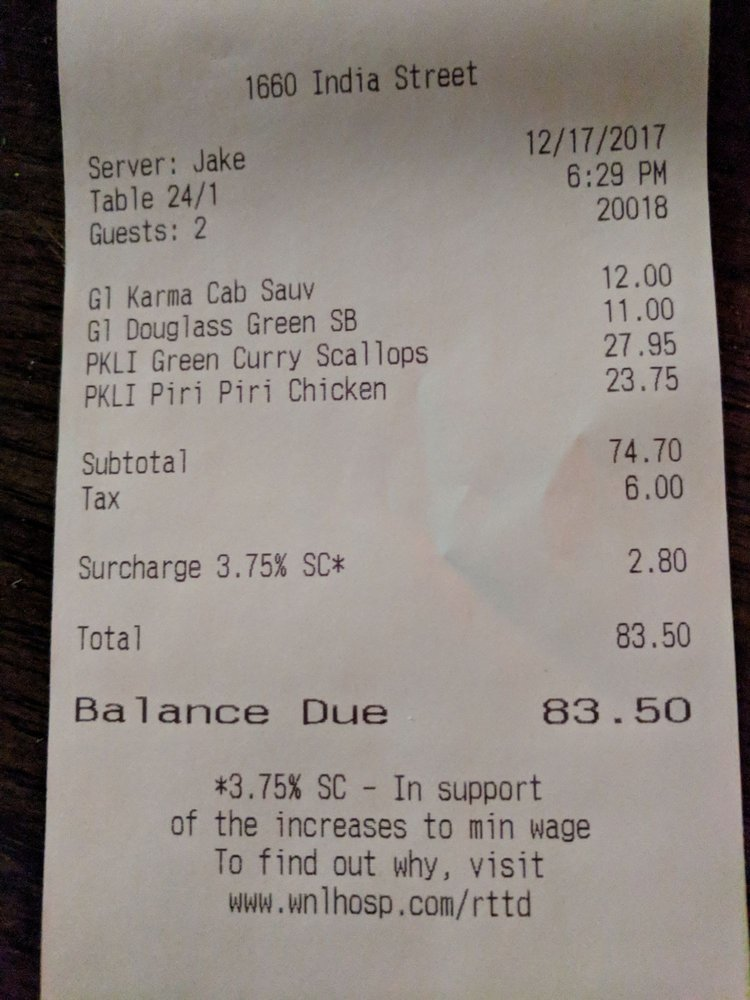

---------------
PROCESSED IMAGE
--------------






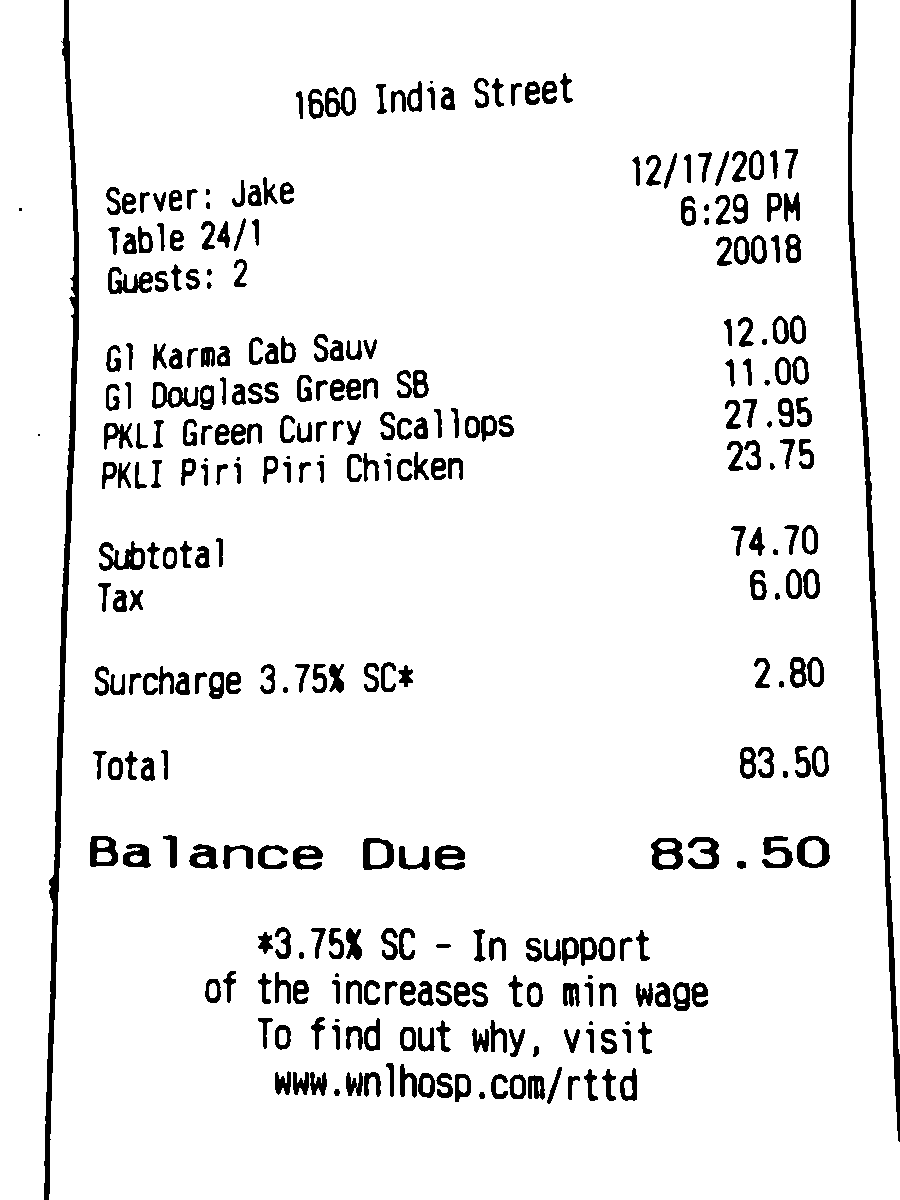

In [99]:
def rotate_image(input_file, output_file, angle):
    with WandImage(filename=input_file) as img:
        width, height = img.size
        if width < height:
            angle = 0
        with img.clone() as rotated:
            rotated.rotate(angle)
            rotated.save(filename=output_file)

def deskew_image(image,):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 
    scores = []
    angles = np.arange(-5, 6, 1)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)
    best_angle = angles[scores.index(max(scores))]
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)
    return rotated

def run_tesseract(input_file, language="deu"):
    with io.BytesIO() as transfer:
        with WandImage(filename=input_file) as img:
            img.save(transfer)
        with Image.open(transfer) as img:
            image_data = pytesseract.image_to_string(img, lang=language, timeout=60, config="--psm 6")
            return image_data


def rescale_image(img):
    img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
    return img


def grayscale_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def remove_noise(img):
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.erode(img, kernel, iterations=1)
    img = cv2.threshold(cv2.GaussianBlur(img, (5, 5), 0), 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img = cv2.threshold(cv2.bilateralFilter(img, 5, 75, 75), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img = cv2.adaptiveThreshold(cv2.bilateralFilter(img, 9, 75, 75), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 31, 2)
    return img


def remove_shadows(img):
    rgb_planes = cv2.split(img)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)
    result = cv2.merge(result_planes)
    return result

def adjust_orientation(image):
    img = image
    hh, ww, cc = img.shape

    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold the grayscale image
    ret, thresh = cv2.threshold(gray,0,255,0)

    # find outer contour
    cntrs = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

    # get rotated rectangle from outer contour
    rotrect = cv2.minAreaRect(cntrs[0])
    box = cv2.boxPoints(rotrect)
    box = np.int0(box)

    # draw rotated rectangle on copy of img as result
    result = img.copy()
    cv2.drawContours(result,[box],0,(0,0,255),2)

    # get angle from rotated rectangle
    angle = rotrect[-1]

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
    
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle

    return -angle


def enhance_image(img, tmp_path): 
    img = rescale_image(img)
    cv2.imwrite(tmp_path, img)
    rotate_image(tmp_path, tmp_path, adjust_orientation(img))
    img = cv2.imread(tmp_path)
    img = deskew_image(img)
    img = remove_shadows(img)
    img = grayscale_image(img)
    img = remove_noise(img)
    return img

def main(input_image):
    input_path = input_image
    img = cv2.imread(input_path)
    img = enhance_image(img, "/content/tmp.jpg")
    cv2.imwrite("/content/tmp.jpg", img)
    cv2_imshow(img)
    return run_tesseract("/content/tmp.jpg", "deu")

print('---------------\nORIGINAL IMAGE\n--------------')
print('\n\n\n')
cv2_imshow(cv2.imread('/content/1060-receipt.jpg'))
'\n\n\n'
print('---------------\nPROCESSED IMAGE\n--------------')
print('\n\n\n')
rawtext = main("/content/1060-receipt.jpg")

# RegEx parsing





In [101]:

class Receipt(object):

    def __init__(self, raw):
        self.sum_keys = {"summe","summe eur","gesamtbetrag","gesantbetrag","gesamt","total","sum","zwischensumme","bar","te betalen","rockgeld","rusckgeld","rückgeld"}
        self.phos = ''
        self.lines = raw
        self.normalize()
        self.parse()
        self.date=''
        self.tax=''
        self.sum=''

    def normalize(self):
        self.lines = [
            line.lower() for line in self.lines if line.strip()
        ]

    def parse(self):
        self.normalize()
        self.date = "Date: " + self.find_date()
        self.sum = "Total: " + self.find_sum()
        self.tax = "Tax: " + self.find_tax()
        self.phos = "Phone numbers: " + self.find_phnos()

    def match_close(self, keyword, accuracy=0.6):
        ulines = []
        for line in self.lines:
            words = line.split()
            matches = get_close_matches(keyword, words, 1, accuracy)
            if matches:
                ulines.append(line)
        return ulines

    def find_date(self):
        datelist=[]
        for line in self.lines:  
            dates = datefinder.find_dates(line)
            for date in dates:
                datelist.append(date)
            if(len(datelist)!=0):
                return datelist[0].ctime()
        return "Date not found."

    def find_sum(self):
        sums = []
        for sum_key in self.sum_keys:
            sum_lines = self.match_close(sum_key)
            for sum_line in sum_lines:
                sum_line = sum_line.replace(",", ".")
                sum_float = re.search('\d+(\.\s?|,\s?|[^a-zA-Z\d])\d{2}', sum_line)
                if sum_float:
                    sums.append(sum_float.group(0))
        if(len(sums)==0):
            return "Total not found."
        return max(sums)

    def find_tax(self):
        taxs = []
        tax_lines = self.match_close('tax')
        for tax_line in tax_lines:
            tax_line = tax_line.replace(",", ".")
            tax_float = re.search('\d+(\.\s?|,\s?|[^a-zA-Z\d])\d{2}', tax_line)
            if tax_float:
                taxs.append(tax_float.group(0))
        if(len(taxs)==0):
            return "Tax not found."
        return max(taxs)

    def find_phnos(self):
        phnos=''
        for line in self.lines:
            res = re.search('^\s*(?:\+?(\d{1,3}))?[-. (]*(\d{3})[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\s*$', line)
            if res:
                phnos = phnos + ',' + res.group(0)
        if(len(phnos)!=0):
            return phnos
        return "Phone numbers not found."

r = Receipt(rawtext.split('\n'))
r.parse()
#print(r.lines)
print(r.date)
print(r.sum)
print(r.tax)
print(r.phos)

Date: Tue Jul 12 00:00:00 2022
Total: 83.50
Tax: 6.00
Phone numbers: Phone numbers not found.
